# confusion_matrix

This notebook can be run via papermill with something like this:
```
papermill confusion_matrix.ipynb get-random-bounding-boxes/reports/job27/job27-turkle-results.ipynb -y "
TURKLE_RESULTS_CSV_PATH: get-random-bounding-boxes/reports/job27/job27-turkle-results.csv"
```

In [1]:
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import itertools
from pandasql import sqldf
import spatialite
import os
import subprocess
import numpy as np

In [2]:
TURKLE_RESULTS_CSV_PATH = '/home/aubrey/Desktop/CRB-Damage-Survey-Validation/index-Batch_7_results.csv'
DATABASE = 'Guam01.db'

In [3]:
assert os.path.exists(DATABASE), f'{DATABASE} does not exist.'

In [4]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel(f'Human label')
    plt.xlabel('Machine label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('confusion-matrix.pdf')
    plt.savefig('confusion_matrix.png')
    plt.show()

In [13]:
# Here I do some data wrangling using SQL applied to a local copy if the Spatialite survey database.
# I find it much easier to do it with these tools rather than using pandas dataframes.

# Note that the Turkle output CSV was downloaded and imported into the survey database manually.

def dbdo(sql, options=''):
    subprocess.check_output(f"spatialite {options} {DATABASE} '{sql}'", shell=True)
        
def build_database_tables():
    dbdo('DROP TABLE IF EXISTS t0;')
    dbdo('DROP TABLE IF EXISTS t1;')
    dbdo('DROP TABLE IF EXISTS t2;')
    dbdo('DROP TABLE IF EXISTS t3;')
    dbdo('''
    CREATE TABLE t0 AS
    SELECT 
        tree_id,
        vcut_count, 
        "Input.damage_index" AS machine_index,
        "Answer.answer" AS human_text,
        "Turkle.Username" AS username
    FROM tree_vcut_count, "index-Batch_7_results"
    WHERE tree_id="Input.tree_id";''')
    dbdo('CREATE TABLE t1 AS SELECT * FROM t0;')
    dbdo('UPDATE t1 SET machine_index = 1 WHERE machine_index=0 AND vcut_count>0;')
    dbdo('CREATE TABLE t2 AS SELECT * FROM t1')
    dbdo('UPDATE t2 SET machine_index = 0  WHERE machine_index=1 AND vcut_count=0;')
    dbdo('CREATE TABLE t3 AS SELECT * FROM t2;')
    dbdo('UPDATE t3 SET machine_index = 0 WHERE machine_index=2 AND vcut_count=0;')

def build_trees1_table():
    """
    trees1 is an updated trees table to which the 3 rules have been applied.
    """
    dbdo('DROP TABLE IF EXISTS trees1;')
    dbdo('''
    CREATE TABLE trees1 AS
    SELECT trees.*, vcut_count 
    FROM trees, tree_vcut_count
    WHERE id = tree_id;''')
    dbdo('UPDATE trees1 SET damage_index = 1 WHERE damage_index=0 AND vcut_count>0;')
    dbdo('UPDATE trees1 SET damage_index = 0 WHERE damage_index=1 AND vcut_count=0;')
    dbdo('UPDATE trees1 SET damage_index = 0 WHERE damage_index=2 AND vcut_count=0;')
    
def create_grid():
    dbdo('DROP TABLE IF EXISTS mean_damage_index1;')
    dbdo('DROP TABLE IF EXISTS grid;')
    dbdo('DROP TABLE IF EXISTS grid1;')
    dbdo('CREATE TABLE grid (id INTEGER PRIMARY KEY AUTOINCREMENT);')
    dbdo('SELECT AddGeometryColumn("grid", "geometry", 3857, "MULTIPOLYGON", "XY");')
    dbdo('INSERT INTO grid (geometry) SELECT SquareGrid(Extent(geometry), 1000) FROM frames;')
    dbdo('CREATE TABLE grid1 (id INTEGER PRIMARY KEY AUTOINCREMENT);')
    dbdo('SELECT AddGeometryColumn("grid1", "geometry", 3857, "POLYGON", "XY");')
    dbdo('''
        INSERT INTO grid1 (geometry) 
        SELECT geometry 
        FROM ElementaryGeometries 
        WHERE f_table_name = "grid" AND origin_rowid=1;''')
    dbdo('CREATE TABLE mean_damage_index1 (id INTEGER PRIMARY KEY AUTOINCREMENT, mean_damage_index DOUBLE);')
    dbdo('SELECT AddGeometryColumn("mean_damage_index1", "geometry", 3857, "POLYGON", "XY");')
    dbdo('''
        INSERT INTO mean_damage_index1 (mean_damage_index, geometry)
        SELECT AVG(damage_index), grid1.geometry 
        FROM trees_view, grid1
        WHERE Contains(grid1.geometry, trees_view.geometry)
        GROUP BY grid1.id;''')
    # Clean up
    dbdo('DROP TABLE grid;')
    dbdo('DROP TABLE grid1;')

In [6]:
def generate_confusion_matrix(db_table_name, caption):
    
    labels = ['zero','light','medium','high','non-recoverable']

    conn = spatialite.connect(DATABASE)

    df = pd.read_sql(f'select * from {db_table_name};', conn)

    def idx2txt(r):
        return labels[int(r.machine_index)]
    df['machine_text'] = df.apply(idx2txt, axis=1)

    cm = metrics.confusion_matrix(list(df.human_text), list(df.machine_text), labels=labels)
    n = np.sum(cm)
    accuracy = np.trace(cm)/n
    false_positives = np.sum(cm[0, 1:])
    false_negatives = np.sum(cm[1:, 0])
    false_positive_rate = false_positives/n
    false_negative_rate = false_negatives/n

    # plt.rcParams.update({'figure.autolayout': True})
    plot = plot_confusion_matrix(cm           = cm, 
                          cmap         = plt.cm.Reds,
                          normalize    = False,
                          target_names = labels,
                          title        = "Confusion Matrix")
        
    bad_images = sqldf('SELECT COUNT(*) FROM df WHERE human_text LIKE "cannot%";').values[0][0]
    n_original = df.shape[0]
    
    print(f'database table: {db_table_name}')
    print(caption)
    print()
    print(f'human: {df["username"][0]}')
    print(f'note: {bad_images} out of {n_original} images could not be classified by {df["username"][0]} because')
    print('these images were of poor quality or did not contain a coconut palm.') 
    print()
    print(f'n: {n}')
    print(f'accuracy: {accuracy:.2f}')
    print(f'false positives: {false_positives} ({false_positive_rate:.2f})')
    print(f'false negatives: {false_negatives} ({false_negative_rate:.2f})')
    print('---------------------------------------------------------------')

# Main

In [7]:
build_database_tables()

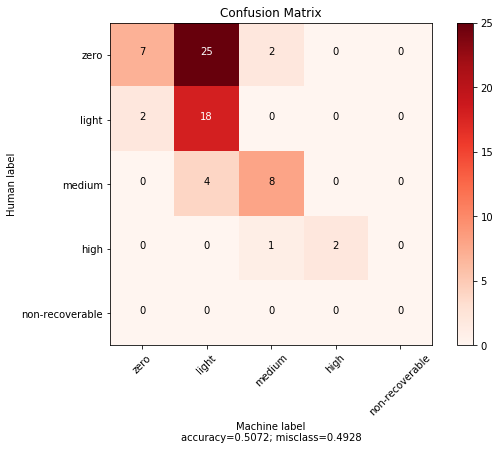

database table: t0
v_cut info not used

human: aubreymoore
note: 31 out of 100 images could not be classified by aubreymoore because
these images were of poor quality or did not contain a coconut palm.

n: 69
accuracy: 0.51
false positives: 27 (0.39)
false negatives: 2 (0.03)
---------------------------------------------------------------


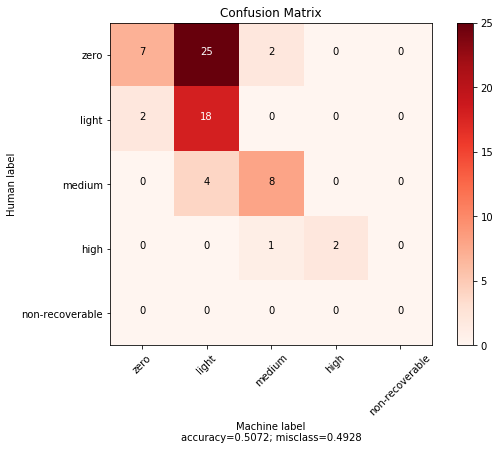

database table: t1
rule 1 implemented: machine_index 0 promoted to 1 if tree has >0 v-cuts

human: aubreymoore
note: 31 out of 100 images could not be classified by aubreymoore because
these images were of poor quality or did not contain a coconut palm.

n: 69
accuracy: 0.51
false positives: 27 (0.39)
false negatives: 2 (0.03)
---------------------------------------------------------------


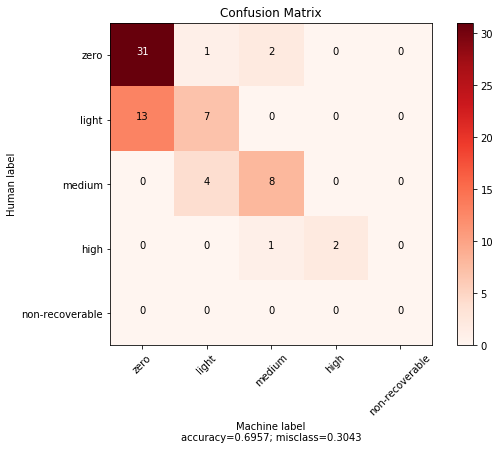

database table: t2
rule 1 implemented, plus
rule 2 implemented: machine_index 1 demoted to 0 if tree has 0 v-cuts

human: aubreymoore
note: 31 out of 100 images could not be classified by aubreymoore because
these images were of poor quality or did not contain a coconut palm.

n: 69
accuracy: 0.70
false positives: 3 (0.04)
false negatives: 13 (0.19)
---------------------------------------------------------------


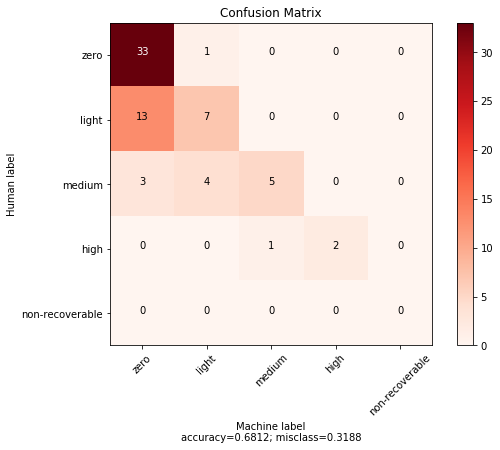

database table: t3
rule 1 and 2 implemented, plus
rule 3 implemented: machine_index 2 demoted to 0 if tree has 0 v-cuts

human: aubreymoore
note: 31 out of 100 images could not be classified by aubreymoore because
these images were of poor quality or did not contain a coconut palm.

n: 69
accuracy: 0.68
false positives: 1 (0.01)
false negatives: 16 (0.23)
---------------------------------------------------------------


In [8]:
captions = {'t0': 'v_cut info not used',
       't1': 'rule 1 implemented: machine_index 0 promoted to 1 if tree has >0 v-cuts',
       't2': 'rule 1 implemented, plus\nrule 2 implemented: machine_index 1 demoted to 0 if tree has 0 v-cuts',
       't3': 'rule 1 and 2 implemented, plus\nrule 3 implemented: machine_index 2 demoted to 0 if tree has 0 v-cuts'}
for db_table_name, caption in captions.items():
    generate_confusion_matrix(db_table_name, caption)

In [14]:
# Create new table in the database called trees1, and mean_damage_index1.
# These tables have been updated in compliance with the 3 rules.
build_trees1_table()
create_grid()